In [1]:
%%capture
!pip install fairlearn

In [2]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [3]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [4]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [5]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [6]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,3,Missing,49,6,27,...,NaN,NaN,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,'Over 60 years',Other,Referral,5,Missing,57,0,21,...,NaN,NaN,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,'30-60 years','Discharged to Home',Other,4,Other,37,2,9,...,NaN,NaN,No,No,No,False,False,False,False,False
51185,Caucasian,Male,'30-60 years',Other,Other,9,InternalMedicine,61,6,27,...,NaN,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,'30-60 years','Discharged to Home',Referral,7,Other,23,0,13,...,NaN,NaN,No,No,Yes,True,False,True,True,False


## data inspectation

In [7]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [8]:
#@markdown
unique_feature_values = x_raw.apply(lambda col: col.unique())
unique_feature_values

race                        [Caucasian, AfricanAmerican, Unknown, Other, A...
gender                                                         [Male, Female]
age                         ['Over 60 years', '30-60 years', '30 years or ...
discharge_disposition_id                        ['Discharged to Home', Other]
admission_source_id                              [Emergency, Referral, Other]
time_in_hospital              [3, 5, 4, 9, 7, 8, 11, 2, 1, 6, 12, 13, 14, 10]
medical_specialty           [Missing, Other, InternalMedicine, Emergency/T...
num_lab_procedures          [49, 57, 37, 61, 23, 65, 47, 35, 51, 22, 46, 4...
num_procedures                                          [6, 0, 2, 1, 3, 4, 5]
num_medications             [27, 21, 9, 13, 40, 17, 34, 10, 19, 11, 6, 14,...
primary_diagnosis           [Other, Diabetes, 'Respiratory Issues', 'Muscu...
number_diagnoses                  [9, 5, 7, 4, 6, 8, 3, 2, 1, 16, 15, 13, 11]
max_glu_serum                                         [nan, Norm

In [9]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'insulin']


In [10]:
#@markdown standardize data types
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True)

In [11]:
#@markdown
%%capture
x_raw.apply(lambda col: col.unique())

In [12]:
x_raw.dtypes

race                                             category
age                                              category
admission_source_id                              category
time_in_hospital                                    int64
medical_specialty                                category
num_lab_procedures                                  int64
num_procedures                                      int64
num_medications                                     int64
primary_diagnosis                                category
number_diagnoses                                    int64
max_glu_serum                                      object
A1Cresult                                          object
insulin                                          category
gender_Male                                         int64
discharge_disposition_id_'Discharged to Home'       int64
change_Ch                                           int64
diabetesMed_Yes                                     int64
medicare_False

In [13]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Male,discharge_disposition_id_'Discharged to Home',change_Ch,diabetesMed_Yes,medicare_False,...,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
86278,5,57,0,21,9,0,0,1,1,0,...,False,False,False,False,False,False,False,True,False,False
30000,4,37,2,9,5,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,False
51185,9,61,6,27,9,1,0,1,1,1,...,False,False,False,False,True,False,False,True,False,False
53902,7,23,0,13,7,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False


 # TODO: Split train, test data 80 train / 20 test


In [14]:
# write your code here

X_train, X_test, y_train, y_test = train_test_split(x_numeric,y_raw, test_size=0.2, random_state=3)

# Problem 2, Part (a)
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [15]:
# write your code here
# initialize a model with RandomForestClassifier
n_estimators = 1
rf = RandomForestClassifier(n_estimators,random_state=3)
# train the model with the training data split
rf.fit(X_train,y_train)




RandomForestClassifier(n_estimators=1, random_state=3)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [16]:
# write your code here

# get model's prediction for the test set
y_pred_baseline = rf.predict(X_test)

# use MetricFrame to get the results
s = X_test['gender_Male'].replace({0:'female', 1:'male'})
metric_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall_score':recall_score,
    'FNR':false_negative_rate,
    'FPR':false_positive_rate,
    'FNR_diff': false_negative_rate_difference,
    'FPR_diff': false_positive_rate_difference,
    'Demographic_parity_ratio': demographic_parity_ratio,
    'Equalized_odds_ratio': equalized_odds_ratio,
    'Selection_rate_diff': selection_rate_difference

}

sample_params = {
    'FNR_diff':{'sensitive_features':s},
    'FPR_diff':{'sensitive_features':s},
    'Demographic_parity_ratio':{'sensitive_features':s},
    'Equalized_odds_ratio':{'sensitive_features':s},
    'Selection_rate_diff':{'sensitive_features':s},
 }


metric_frame = MetricFrame(
    metrics =metric_dict,
    y_true = y_test,
    y_pred = y_pred_baseline,
    sensitive_features= s,
    sample_params=sample_params

)


Print Results

In [17]:
metric_frame.overall

Accuracy                    0.519646
Precision                   0.468262
Recall_score                0.490731
FNR                         0.509269
FPR                         0.456658
FNR_diff                    0.006734
FPR_diff                    0.049964
Demographic_parity_ratio    0.931948
Equalized_odds_ratio        0.896105
Selection_rate_diff         0.033141
dtype: float64

In [18]:
metric_frame.by_group

,Accuracy,Precision,Recall_score,FNR,FPR,FNR_diff,FPR_diff,Demographic_parity_ratio,Equalized_odds_ratio,Selection_rate_diff
gender_Male,,,,,,,,,,
female,0.506726,0.489871,0.493506,0.506494,0.480903,0.0,0.0,1.0,1.0,0.0
male,0.535288,0.440191,0.486772,0.513228,0.430939,0.0,0.0,1.0,1.0,0.0


# Problem 2, Part (b)

Train another classifier with the following value of hyperparameters

In [19]:
# write your code here

n_estimators = 1000
max_depth = 10

rf_max = RandomForestClassifier(n_estimators=1000,max_depth=10, random_state=3)
rf_max.fit(X_train,y_train)


RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=3)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [20]:
y_pred_max = rf_max.predict(X_test)

metric_frame_max = MetricFrame(
    metrics =metric_dict,
    y_true = y_test,
    y_pred = y_pred_max,
    sensitive_features= s,
    sample_params=sample_params
)

metric_frame_max.overall


Accuracy                    0.617387
Precision                   0.594005
Recall_score                0.475463
FNR                         0.524537
FPR                         0.266309
FNR_diff                    0.021267
FPR_diff                    0.041523
Demographic_parity_ratio    0.875299
Equalized_odds_ratio        0.855048
Selection_rate_diff         0.047644
dtype: float64

In [21]:
metric_frame_max.by_group

,Accuracy,Precision,Recall_score,FNR,FPR,FNR_diff,FPR_diff,Demographic_parity_ratio,Equalized_odds_ratio,Selection_rate_diff
gender_Male,,,,,,,,,,
female,0.602691,0.612676,0.484230,0.515770,0.286458,0.0,0.0,1.0,1.0,0.0
male,0.635179,0.568182,0.462963,0.537037,0.244936,0.0,0.0,1.0,1.0,0.0


In [22]:
metric_frame_max.by_group['Accuracy']['male']

0.6351791530944625

# Problem 2, Part (c)
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [23]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True
s_train = X_train['gender_Male'].replace({0:'female', 1:'male'})
alpha_value = [0.0, 0.3, 0.7, 1.0]
metrics=[]
for alpha in alpha_value:
  for seed in range(10):
    model = AdversarialFairnessClassifier(backend='tensorflow',
                                  predictor_model=[128,64,32,16,8],
                                  adversary_model=[32,16,8],
                                  learning_rate=0.001,
                                  epochs=3,
                                  batch_size=16,
                                  constraints='demographic_parity',
                                  random_state=seed,
                                  shuffle=True,
                                  alpha = alpha)
    model.fit(X_train,y_train,sensitive_features = s_train)
    y_pred_model = model.predict(X_test)
    metric_frame_model = MetricFrame(
        metrics =metric_dict,
        y_true = y_test,
        y_pred = y_pred_model,
        sensitive_features= s,
        sample_params=sample_params
    )
    for metric_name in metric_dict.keys():
      metric_value = metric_frame_model.overall[metric_name]
      metric_male = metric_frame_model.by_group[metric_name]['male']
      metric_female = metric_frame_model.by_group[metric_name]['female']

      metrics.append({
          'alpha':alpha,
          'seed': seed,
          'metric_name':metric_name,
          'metric_value': metric_value,
          'male_value': metric_male,
          'female_value': metric_female
      })

metrics_df = pd.DataFrame(metrics)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

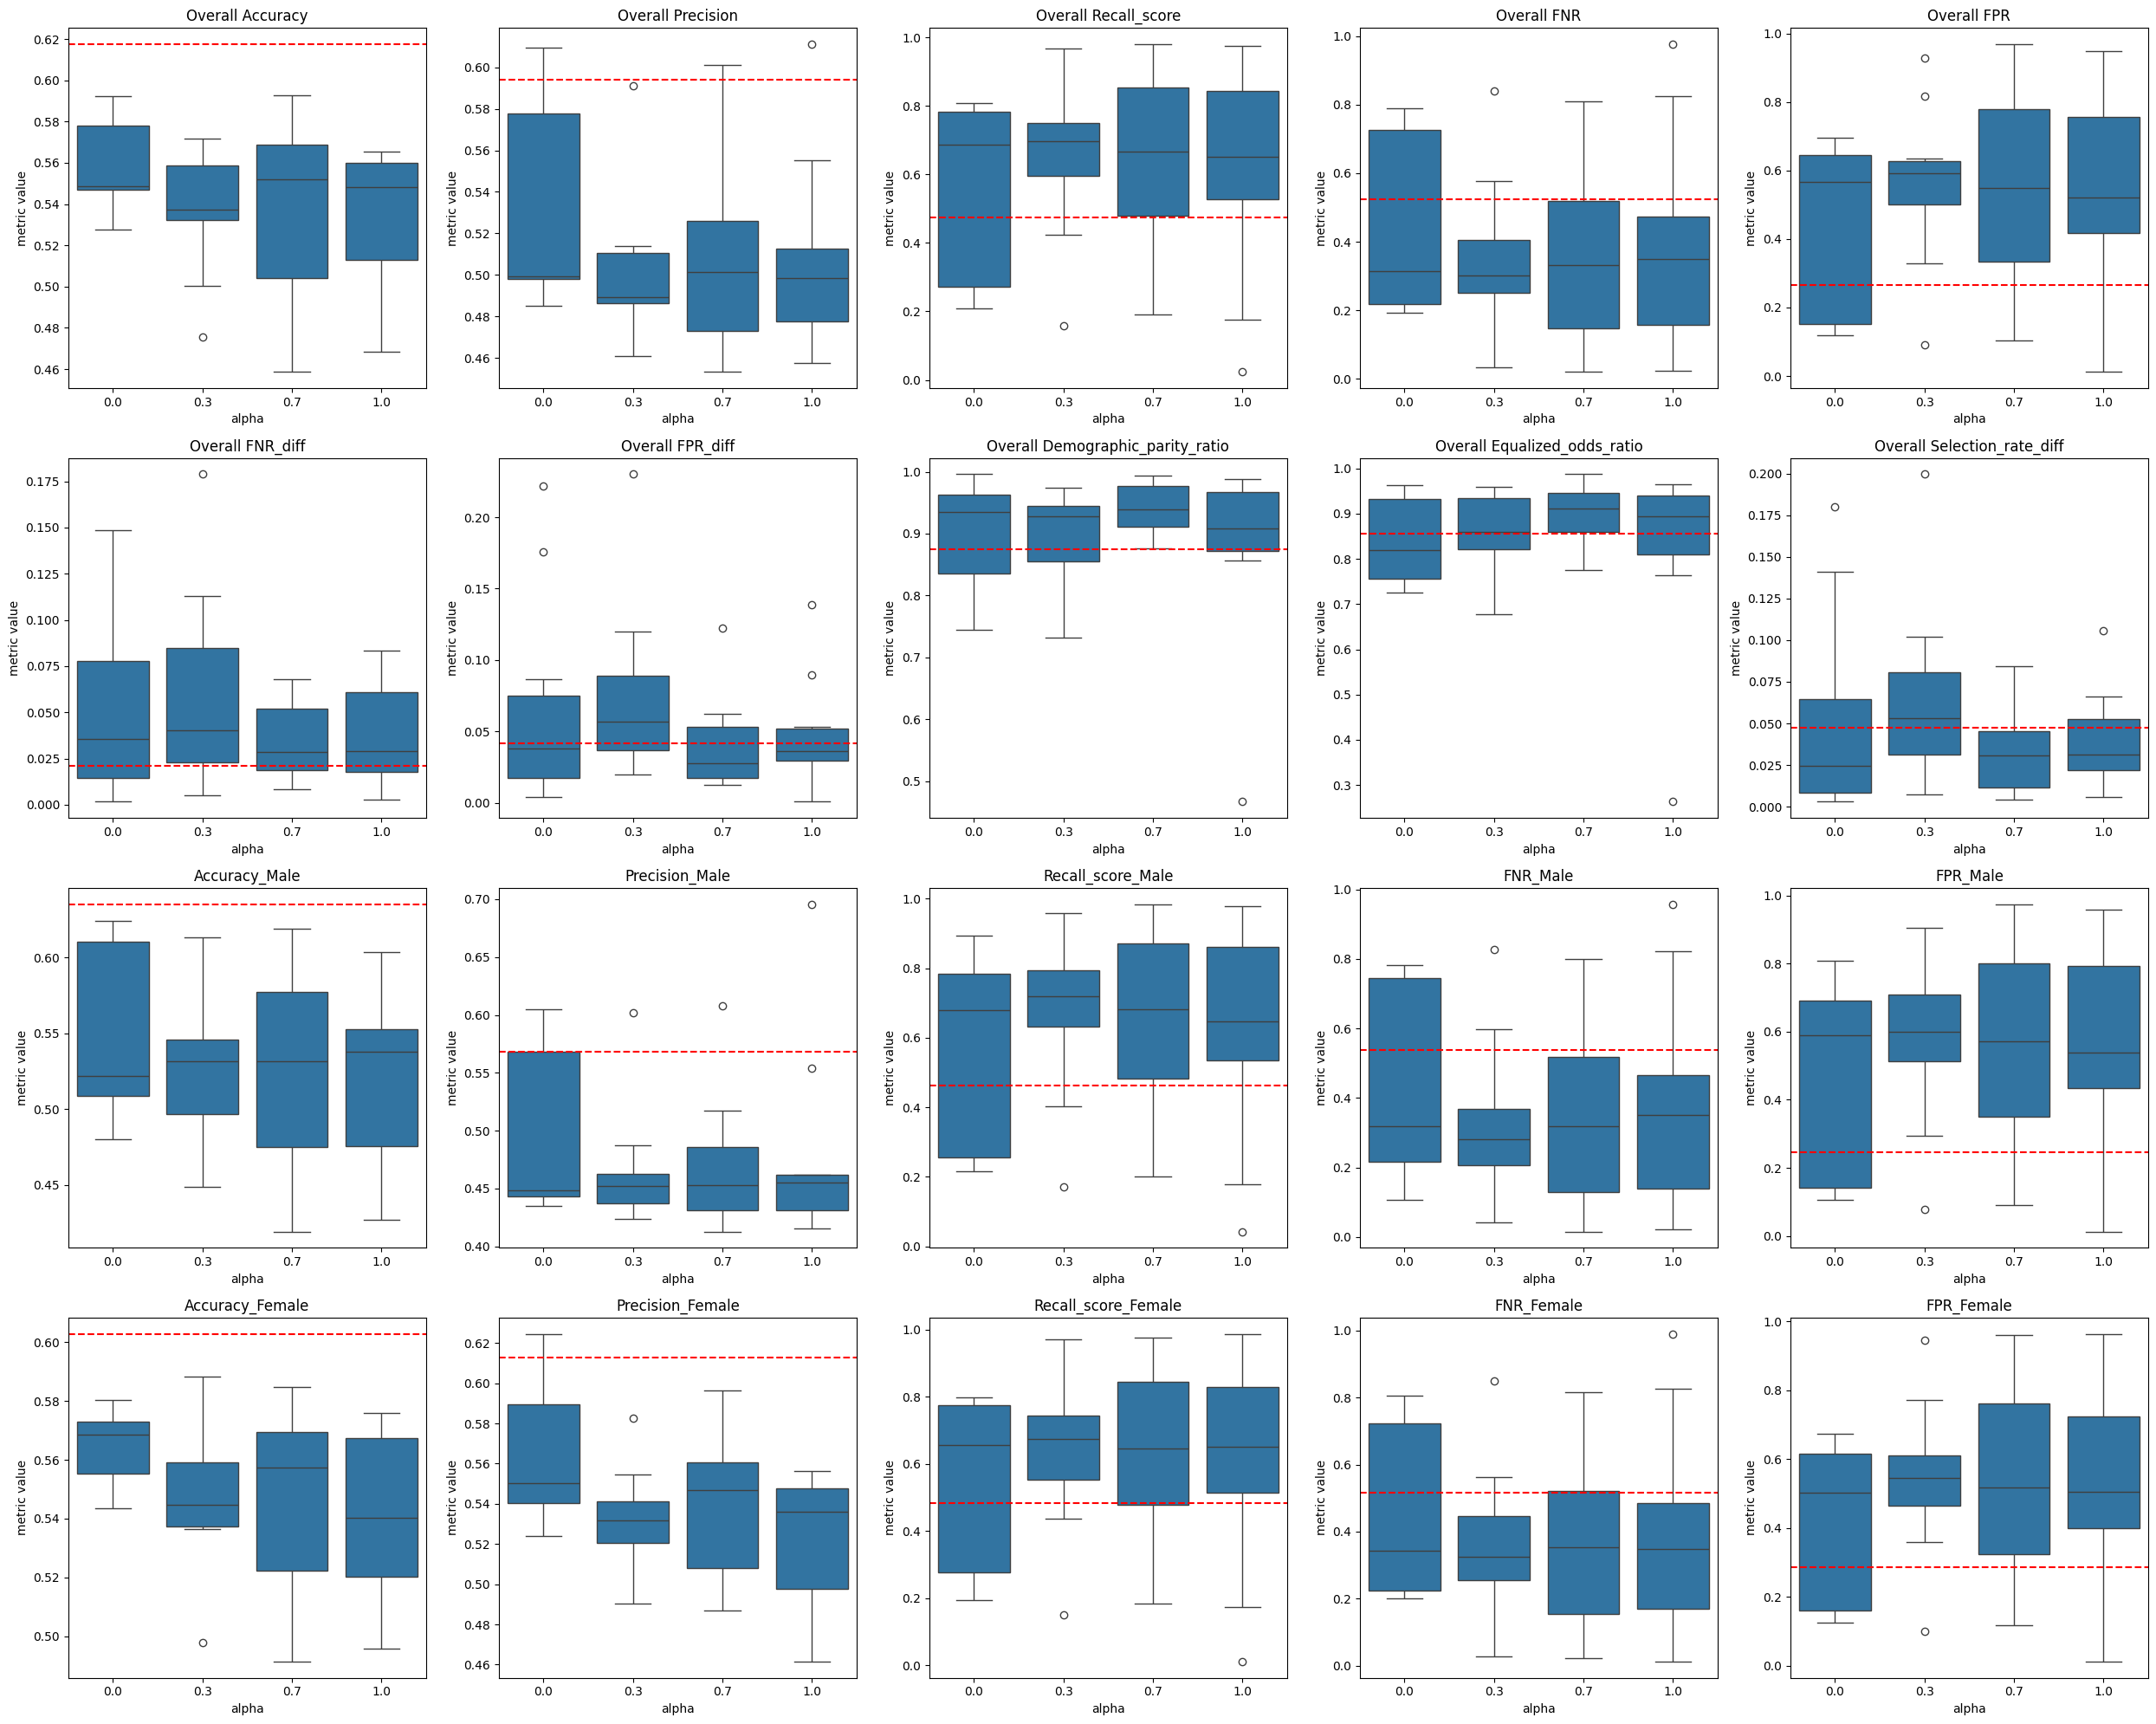

In [25]:
#@markdown ### Plot all our metrics as line plots while varying alpha

nrows=4
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 20))

metric_names = list(metric_dict.keys())
performance = metric_names[:5]
fairness = metric_names [5:]


for index, metric_name in enumerate(performance):
  sns.boxplot(data=metrics_df[metrics_df['metric_name']==metric_name],
              x = 'alpha',y='metric_value',ax=axs[0,index])
  axs[0,index].set_xlabel("alpha")
  axs[0,index].set_ylabel("metric value")
  axs[0,index].axhline(y=metric_frame_max.overall[metric_name],color='red',linestyle='--')
  axs[0,index].set_title(f'Overall {metric_name}')


for index, metric_name in enumerate(fairness):
  sns.boxplot(data=metrics_df[metrics_df['metric_name']==metric_name],
              x = 'alpha',y='metric_value',ax=axs[1,index])
  axs[1,index].set_xlabel("alpha")
  axs[1,index].set_ylabel("metric value")
  axs[1,index].axhline(y=metric_frame_max.overall[metric_name],color='red',linestyle='--')
  axs[1,index].set_title(f'Overall {metric_name}')

for index, metric_name in enumerate(performance):
  sns.boxplot(data=metrics_df[metrics_df['metric_name']==metric_name],
              x = 'alpha',y='male_value',ax=axs[2,index])
  axs[2,index].set_xlabel("alpha")
  axs[2,index].set_ylabel("metric value")
  axs[2,index].axhline(y=metric_frame_max.by_group[metric_name]['male'],color='red',linestyle='--')
  axs[2,index].set_title(f'{metric_name}_Male')

for index, metric_name in enumerate(performance):
  sns.boxplot(data=metrics_df[metrics_df['metric_name']==metric_name],
              x = 'alpha',y='female_value',ax=axs[3,index])
  axs[3,index].set_xlabel("alpha")
  axs[3,index].set_ylabel("metric value")
  axs[3,index].axhline(y=metric_frame_max.by_group[metric_name]['female'],color='red',linestyle='--')
  axs[3,index].set_title(f'{metric_name}_Female')





plt.tight_layout()
plt.show()







# Problem 2, Part (d)
### **Threshold Optimizer Post-processing intervention**



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
<ipython-input-26-6170537ae06e>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,index].set_xticklabels(labels)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
<ipython-input-26-6170537ae06e>:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0,index].set_xticklabels(labels)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=fl

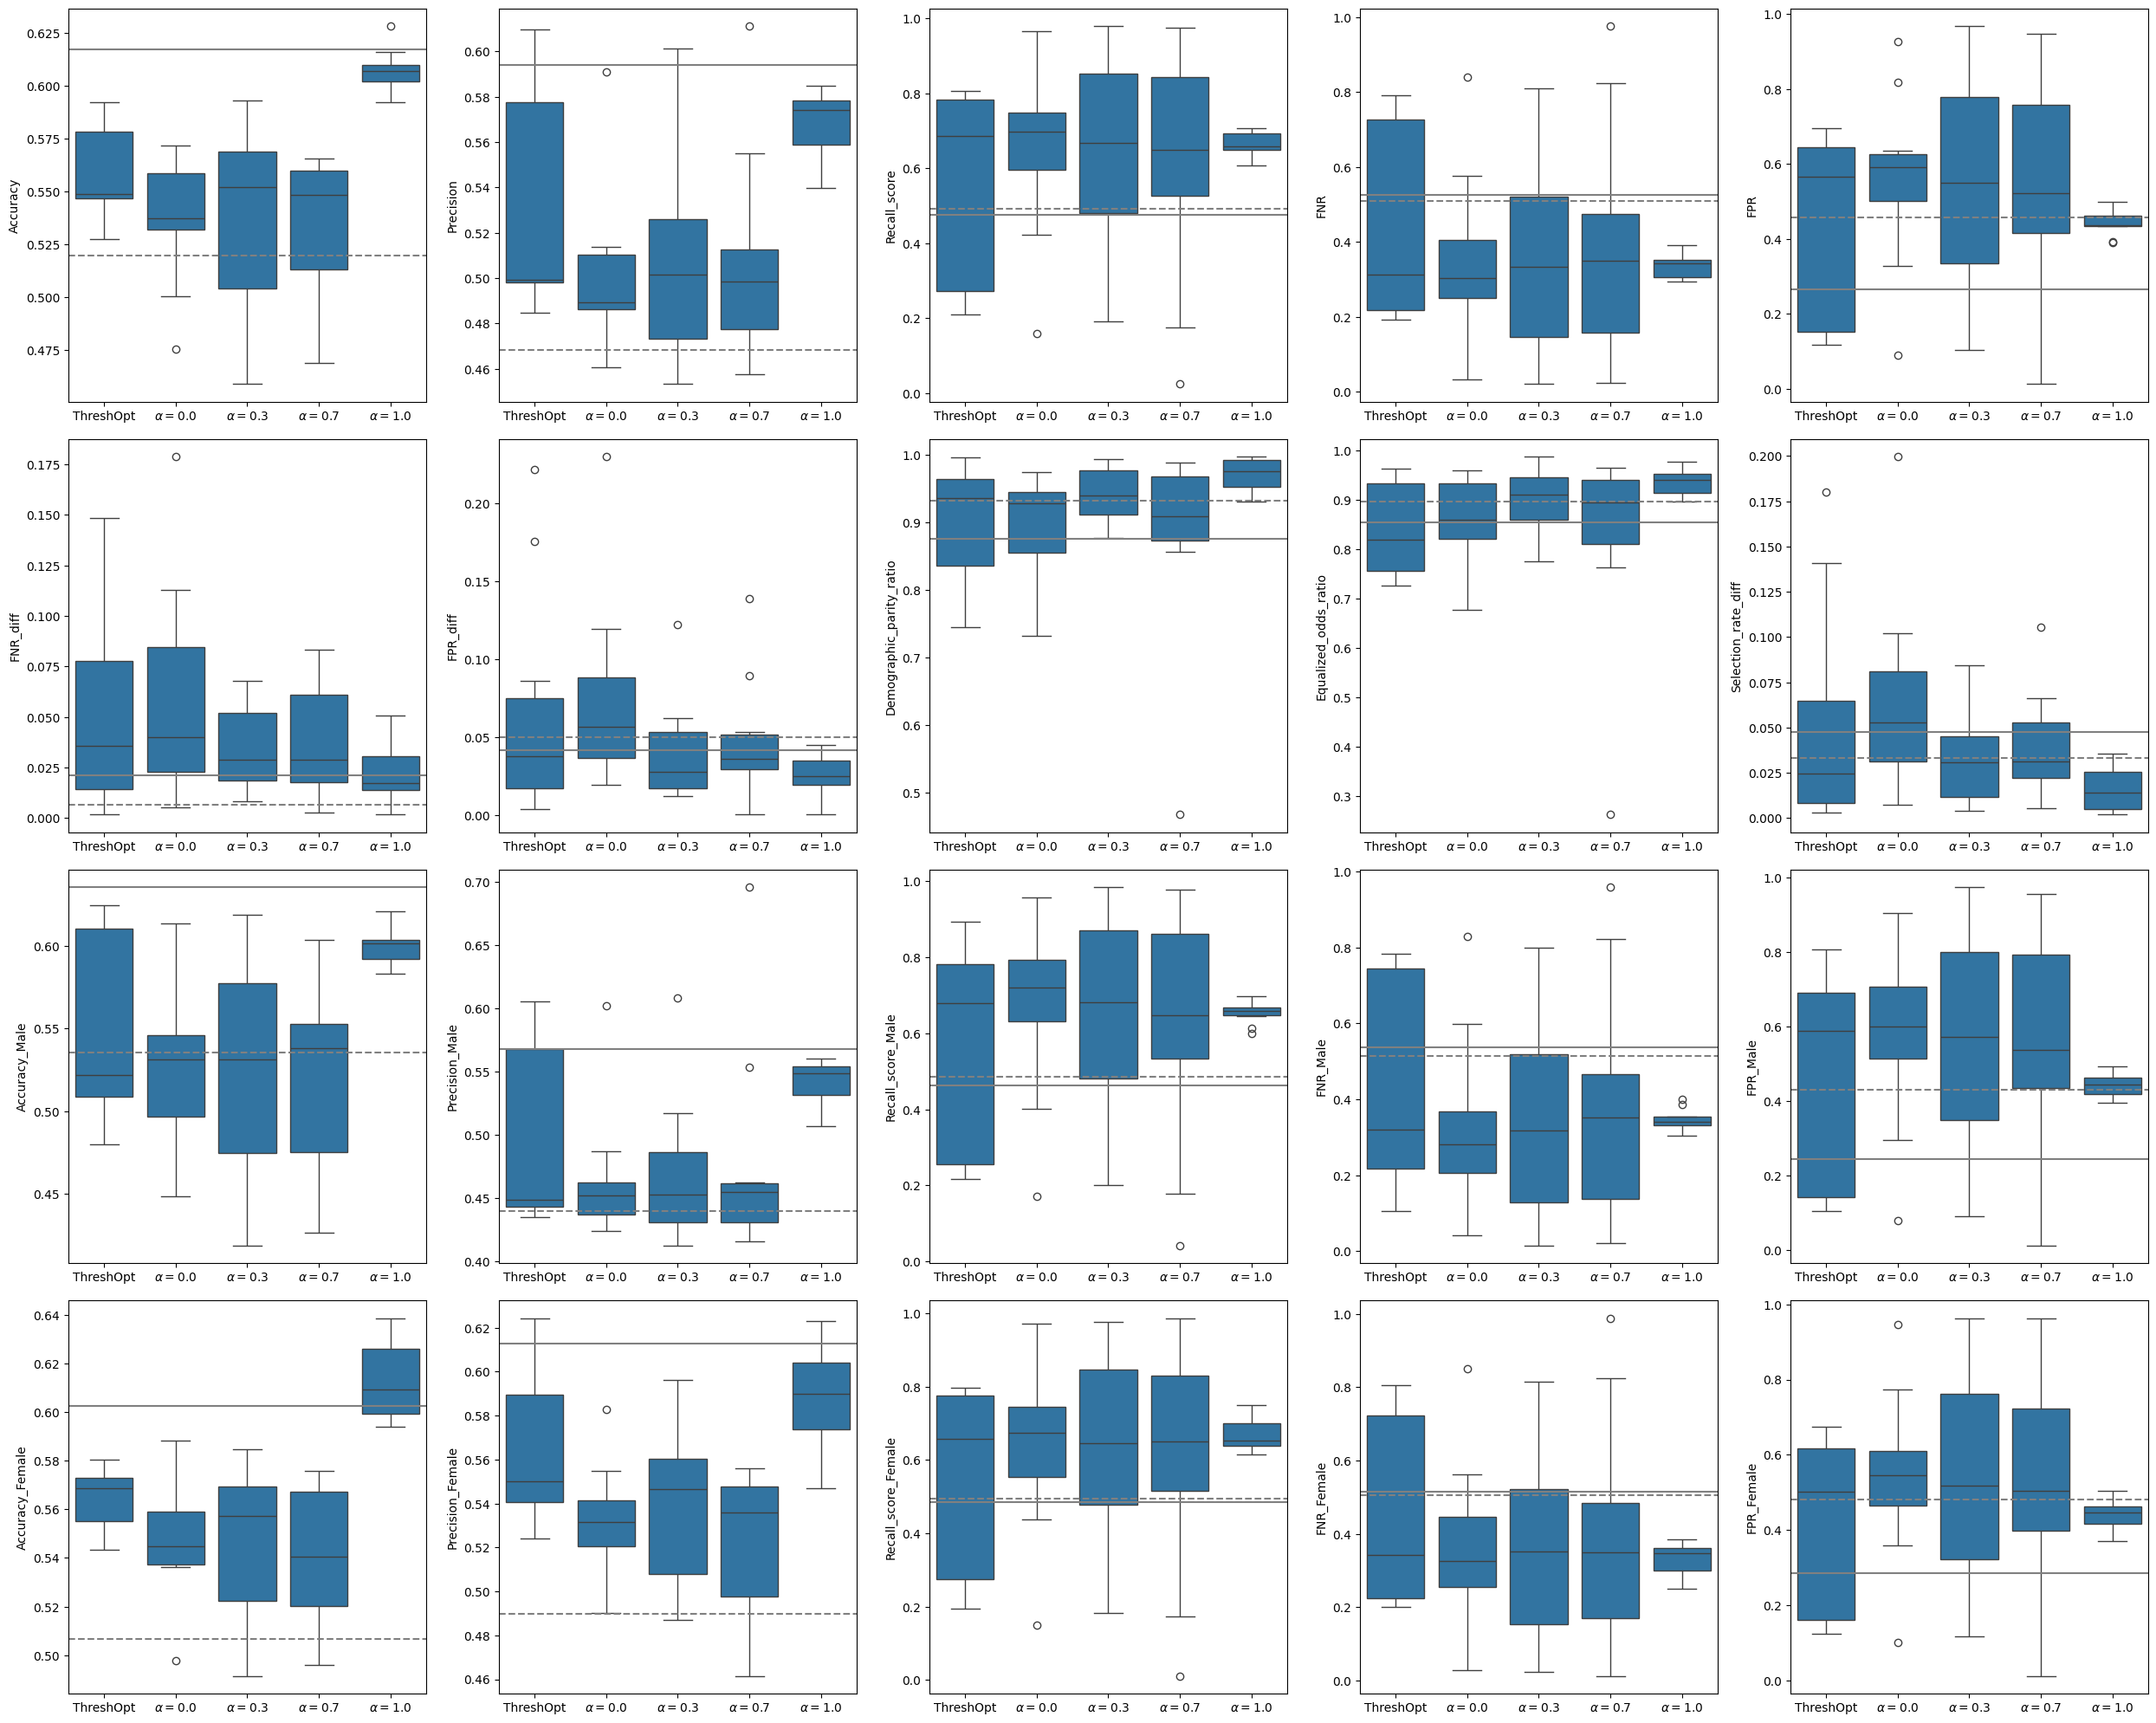

In [26]:
##@markdown Fit the ThresholdOptimizer model here

metrics_post=[]
# generate 10 different train/test splits
for i in range(10):
  #set random number for seed
  random_seed = np.random.randint(0,1000)
  X_train, X_test, y_train, y_test = train_test_split(x_numeric,y_raw, test_size=0.2, random_state= random_seed)
  sensitive_test = X_test['gender_Male'].replace({0:'female', 1:'male'})
  sensitive_train = X_train['gender_Male'].replace({0:'female', 1:'male'})
  #train the hyperparameter-tuned classifier
  rf_hyper = RandomForestClassifier(n_estimators=1000,max_depth=10, random_state=random_seed)
  #fit the model
  rf_hyper.fit(X_train,y_train)


  #Make the post processed model
  postprocessed_model = ThresholdOptimizer(
    estimator= rf_hyper,
    constraints='equalized_odds',
    objective='balanced_accuracy_score',
    prefit=True,
    predict_method='predict_proba'
  )
  #fit the post processed model
  postprocessed_model.fit(X_train,y_train,sensitive_features=sensitive_train)
  y_pred_post = postprocessed_model.predict(X_test,sensitive_features = sensitive_test)

  #evaluate the metrics for the post-processed model
  metric_frame_post = MetricFrame(
    metrics = metric_dict,
    y_true = y_test,
    y_pred = y_pred_post,
    sensitive_features= sensitive_test,
    sample_params=sample_params
  )

  #Evaluate metrics and store the metrics in list
  for metric_name in metric_dict.keys():
    metric_value = metric_frame_post.overall[metric_name]
    metric_male = metric_frame_post.by_group[metric_name]['male']
    metric_female = metric_frame_post.by_group[metric_name]['female']

    metrics_post.append({
        'alpha':'ThreshOpt',
        'seed': seed,
        'metric_name':metric_name,
        'metric_value': metric_value,
        'male_value': metric_male,
        'female_value': metric_female
    })




metrics_df_post = pd.DataFrame(metrics_post)

combined_metrics_df = pd.concat([metrics_df, metrics_df_post], ignore_index=True)
metric_names = list(metric_dict.keys())

nrows=4
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 20))

performance = metric_names[:5]
fairness = metric_names [5:]

for index, metric_name in enumerate(performance):
  sns.boxplot(data=combined_metrics_df[combined_metrics_df['metric_name']==metric_name],
              x = 'alpha',y='metric_value',ax=axs[0,index])
  axs[0,index].set_xlabel("")
  axs[0,index].set_ylabel(metric_name)
  labels = [r'$\alpha = 0.0$', r'$\alpha = 0.3$', r'$\alpha = 0.7$', r'$\alpha = 1.0$','ThreshOpt']
  axs[0,index].set_xticklabels(labels)
  #horizontal line for 4a metrics (untuned)
  axs[0,index].axhline(y=metric_frame.overall[metric_name],color='grey', linestyle='--', label='Untuned rf')
  #horizontal line for 4b (tuned)
  axs[0,index].axhline(y=metric_frame_max.overall[metric_name],color='grey', linestyle='-', label='Tuned rf')

#Fairness metrics plots on second row
for index, metric_name in enumerate(fairness):
  sns.boxplot(data=combined_metrics_df[combined_metrics_df['metric_name']==metric_name],
              x = 'alpha',y='metric_value',ax=axs[1,index])
  axs[1,index].set_xlabel("")
  axs[1,index].set_ylabel(metric_name)
  labels = [r'$\alpha = 0.0$', r'$\alpha = 0.3$', r'$\alpha = 0.7$', r'$\alpha = 1.0$','ThreshOpt']
  axs[1,index].set_xticklabels(labels)
  #horizontal line for 4a metrics (untuned)
  axs[1,index].axhline(y=metric_frame.overall[metric_name],color='grey', linestyle='--', label='Untuned rf')
  #horizontal line for 4b (tuned)
  axs[1,index].axhline(y=metric_frame_max.overall[metric_name],color='grey', linestyle='-', label='Tuned rf')

for index, metric_name in enumerate(performance):
  sns.boxplot(data=combined_metrics_df[combined_metrics_df['metric_name']==metric_name],
              x = 'alpha',y='male_value',ax=axs[2,index])
  axs[2,index].set_xlabel("")
  axs[2,index].set_ylabel(f"{metric_name}_Male")
  labels = [r'$\alpha = 0.0$', r'$\alpha = 0.3$', r'$\alpha = 0.7$', r'$\alpha = 1.0$','ThreshOpt']
  axs[2,index].set_xticklabels(labels)
  #horizontal line for 4a metrics (untuned)
  axs[2,index].axhline(y=metric_frame.by_group[metric_name]['male'],color='grey', linestyle='--', label='Untuned rf')
  #horizontal line for 4b (tuned)
  axs[2,index].axhline(y=metric_frame_max.by_group[metric_name]['male'],color='grey', linestyle='-', label='Tuned rf')

for index, metric_name in enumerate(performance):
  sns.boxplot(data=combined_metrics_df[combined_metrics_df['metric_name']==metric_name],
              x = 'alpha',y='female_value',ax=axs[3,index])
  axs[3,index].set_xlabel("")
  axs[3,index].set_ylabel(f"{metric_name}_Female")
  labels = [r'$\alpha = 0.0$', r'$\alpha = 0.3$', r'$\alpha = 0.7$', r'$\alpha = 1.0$','ThreshOpt']
  axs[3,index].set_xticklabels(labels)
  #horizontal line for 4a metrics (untuned)
  axs[3,index].axhline(y=metric_frame.by_group[metric_name]['female'],color='grey', linestyle='--', label='Untuned rf')
  #horizontal line for 4b (tuned)
  axs[3,index].axhline(y=metric_frame_max.by_group[metric_name]['female'],color='grey', linestyle='-', label='Tuned rf')





plt.tight_layout()
plt.show()










